In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
from deepsphere.healpy_layers import HealpySmoothing

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm
from icecream import ic
from scipy.stats import binned_statistic

from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import logger, input_output, files, scales, power_spectra, parameters

from deep_lss.utils import configuration

from msi.utils import preprocessing, dataset

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"

# for the white noise level
dlss_conf = configuration.load_deep_lss_config("/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_config.yaml")

with_cross_z = False
with_white_noise = True

24-09-24 08:32:57 configuratio INF   Loaded the config 


In [4]:
# with_lensing = True
# with_clustering = False
# params = ["Om", "s8", "w0", "Aia", "n_Aia"]

In [5]:
with_lensing = False
with_clustering = True
params = ["Om", "s8", "w0", "bg", "n_bg"]

In [6]:
# with_lensing = True
# with_clustering = True
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bg", "n_bg"]

# white noise dset

24-09-24 08:32:58 configuratio INF   Loaded the config 
24-09-24 08:32:58 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021  165.89861751
  242.69662921  316.71554252  378.94736842] from the dlss config 
24-09-24 08:32:58 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
24-09-24 08:32:58 preprocessin INF   Using n_bins = 33 from the msfm config 
24-09-24 08:32:58 preprocessin INF   Loading the pre-binned Cls 
24-09-24 08:32:58 input_output INF   Array shapes: 
24-09-24 08:32:58 input_output INF   fiducial/i_example = (35920,) 
24-09-24 08:32:58 input_output INF   fiducial/i_noise   = (35920,) 
24-09-24 08:32:59 input_output INF   fiducial/cls/binned = (35920, 32, 36) 
24-09-24 08:32:59 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-09-24 08:32:59 input_output INF   grid/cosmo         = (2500, 400, 12) 
24-09-24 08:32:59 input_output INF   grid/i_example     = (2500, 400) 
24-09-24 08:32:59 input_ou

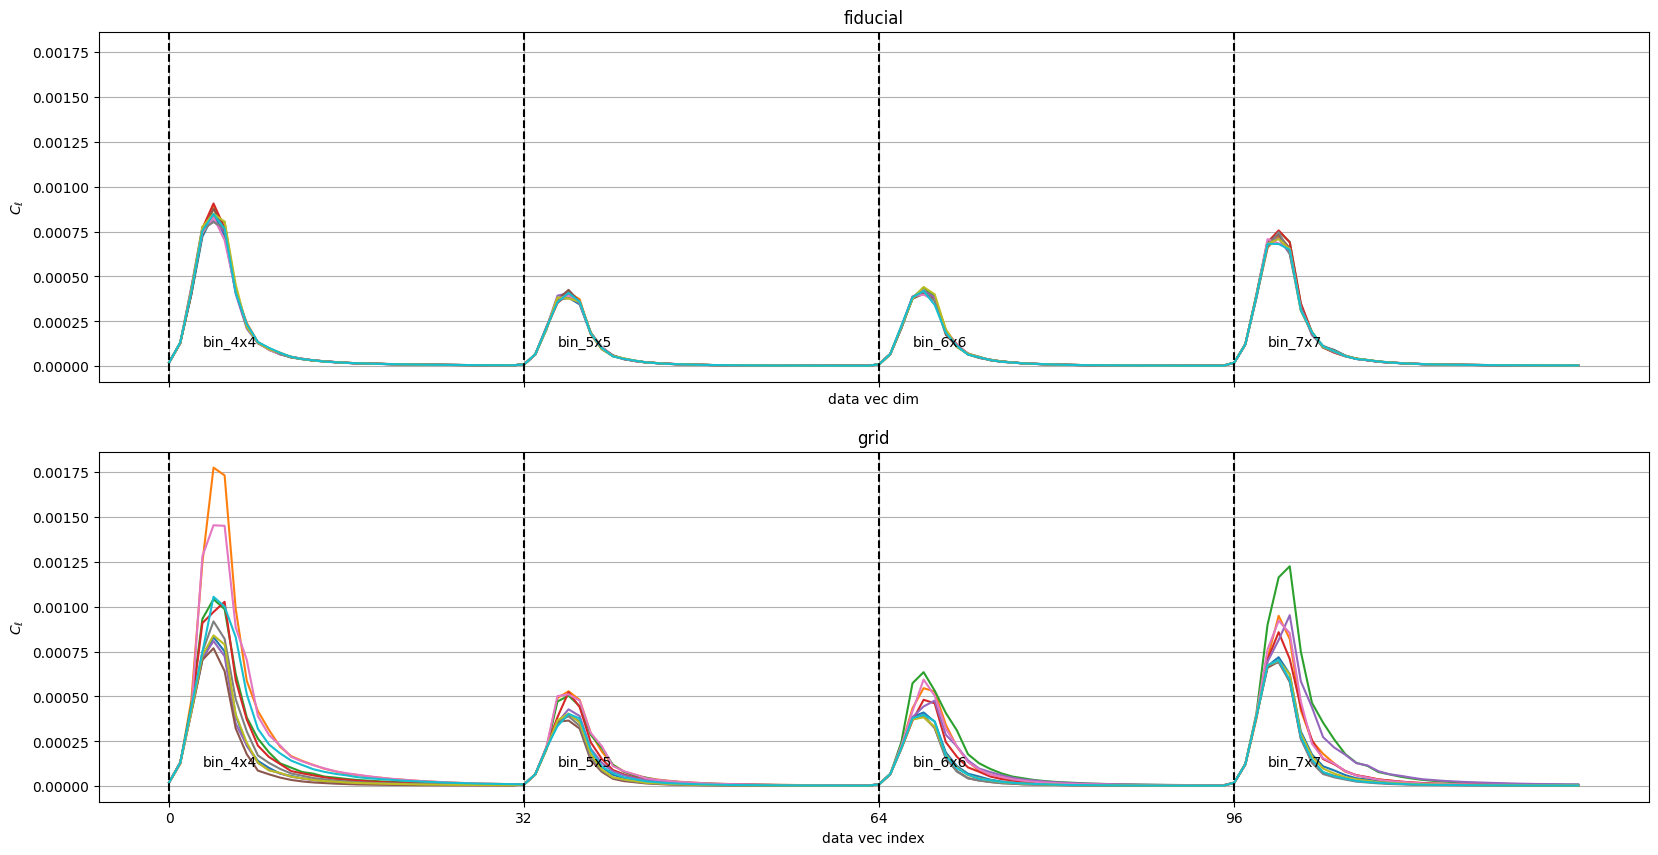

In [7]:
cl_dset_train, cl_dset_test, out_dict = dataset.get_binned_power_spectra_dset(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    with_gaussian_noise=with_white_noise,
    # l_mins=4*[None],
    # l_maxs=4*[None],
    # preprocessing
    apply_log=False,
)

# maps directly

In [29]:
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0513.tfrecord"

# no masking after smoothing the maps
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/fiducial/debug/DESy3_fiducial_dmb_0000.tfrecord"

In [30]:
pipe = FiducialPipeline(
    conf=msfm_conf,
    params=[],
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
)

dset = pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=1,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=0,
    is_eval=True,
)

n_side = 512
n_pix = hp.nside2npix(n_side)

params = pipe.params
n_params = len(params)
n_maps = 2 * len(params) + 1 
n_noise = 2
data_vec_pix = pipe.data_vec_pix
n_z = pipe.n_z_metacal + pipe.n_z_maglim
n_z_metacal = pipe.n_z_metacal

24-09-24 08:38:12     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-24 08:38:12     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-24 08:38:12 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-09-24 08:38:12 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-09-24 08:38:12 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-09-24 08:38:12 fiducial_pip INF   Including noise_indices = [0] 
24-09-24 08:38:13 fiducial_pip INF   Interleaving with n_readers = 1 
24-09-24 08:38:13 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-09-24 08:38:13 fiducial_pip WAR   Tracing _augmentations 
24-09-24 08:38

In [31]:
smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    "arcmin": dlss_conf["scale_cuts"]["arcmin"],
    "data_path": ".",
}
mask_dict = files.get_tomo_dv_masks(msfm_conf)

fwhm = []
white_noise_sigma = []
mask = []
if with_lensing:
    fwhm += dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"]
    white_noise_sigma += dlss_conf["scale_cuts"]["lensing"]["white_noise_sigma"]
    mask += [mask_dict["metacal"]]
if with_clustering:
    fwhm += dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
    white_noise_sigma += dlss_conf["scale_cuts"]["clustering"]["white_noise_sigma"]
    mask += [mask_dict["maglim"]]
smoothing_kwargs["fwhm"] = fwhm
if with_white_noise:
    smoothing_kwargs["white_noise_sigma"] = white_noise_sigma
smoothing_kwargs["mask"] = np.concatenate(mask, axis=1)

noisy_smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-09-24 08:38:13     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
Using the per channel smoothing repetitions [6 3 2 1]
Using the per channel smoothing scales sigma = [29.65 20.96 17.12 12.1 ] arcmin, fwhm = [69.81 49.36 40.31 28.5 ] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma ListWrapper([0.520092784, 0.206405445, 0.149487804, 0.13530551]) to the smoothed map. Note that networks outputs are nondeterministic, even for training=False
Warning, you're adding white noise to the maps but haven't provided a mask! The noise will extend to the padding


Successfully built the smoothing layer


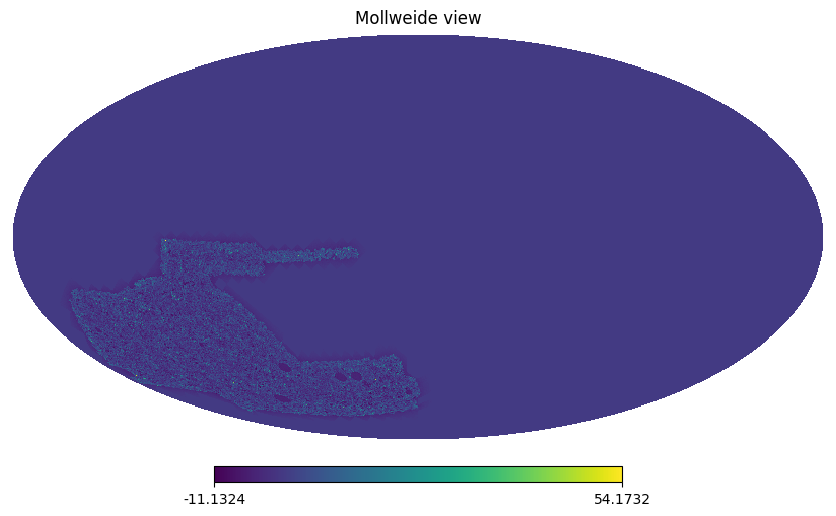

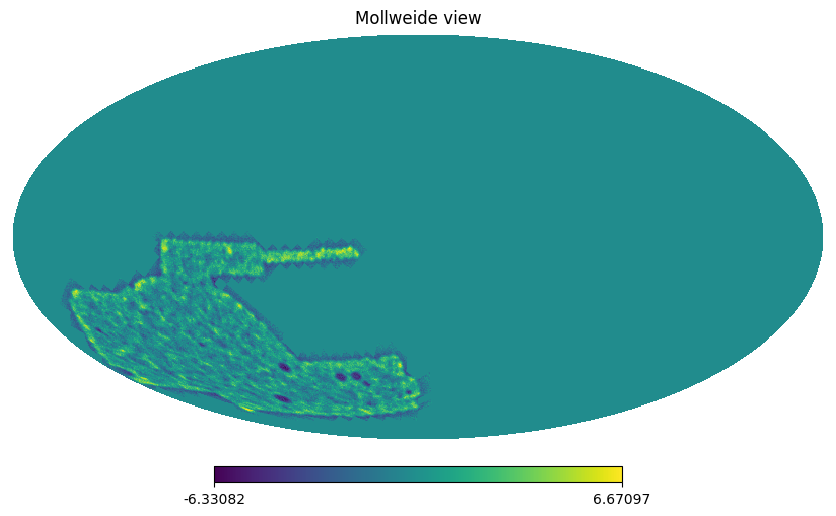

In [32]:
i_z = 0

for dv, tfr_cls, index in dset.take(1):
    tfr_cls = np.squeeze(tfr_cls.numpy())
    
    map_raw = np.zeros((n_pix, dv.shape[-1]))
    map_raw[data_vec_pix] = dv[0]

    smoothed_dv = noisy_smoothing_layer(dv)
    map_smoothed = np.zeros((n_pix, smoothed_dv.shape[-1]))
    map_smoothed[data_vec_pix] = smoothed_dv[0]
    
hp.mollview(map_raw[:,i_z], nest=True)
hp.mollview(map_smoothed[:,i_z], nest=True)

In [33]:
# map_alms = power_spectra.get_alms(map_smoothed, nest=True)
map_alms = power_spectra.get_alms(map_raw, nest=True)
map_cls = power_spectra.get_cls(map_alms, with_cross=with_cross_z)

ells = np.arange(0, 3 * msfm_conf["analysis"]["n_side"])
bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"],
    msfm_conf["analysis"]["power_spectra"]["l_max"],
    msfm_conf["analysis"]["power_spectra"]["n_bins"],
)

binned_map_cls = []
binned_tfr_cls = []
for i in range(map_cls.shape[-1]):
    binned_map_cls.append(binned_statistic(ells, map_cls[:,i], statistic="mean", bins=bins)[0])  
    binned_tfr_cls.append(binned_statistic(ells, tfr_cls[:,i], statistic="mean", bins=bins)[0])  
binned_map_cls = np.stack(binned_map_cls, axis=-1)
binned_tfr_cls = np.stack(binned_tfr_cls, axis=-1)

binned_map_cls = np.concatenate([binned_map_cls[..., i] for i in range(binned_map_cls.shape[-1])], axis=-1)
binned_tfr_cls = np.concatenate([binned_tfr_cls[..., i] for i in range(binned_tfr_cls.shape[-1])], axis=-1)

# comparison

[None]

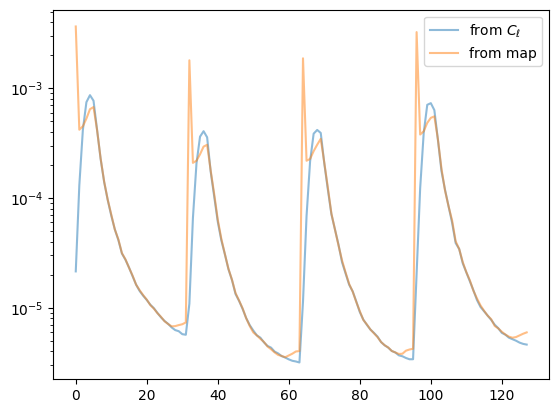

In [34]:
cls_ex = out_dict["fidu/cls"][0,:]
map_ex = binned_map_cls
tfr_ex = binned_tfr_cls

fig, ax = plt.subplots()

ax.plot(cls_ex, label=r"from $C_\ell$", alpha=0.5)
ax.plot(map_ex, label="from map", alpha=0.5)
# ax.plot(tfr_ex, label="from tfr", alpha=0.5)

ax.legend(loc="best")
ax.set(yscale="log")

[None]

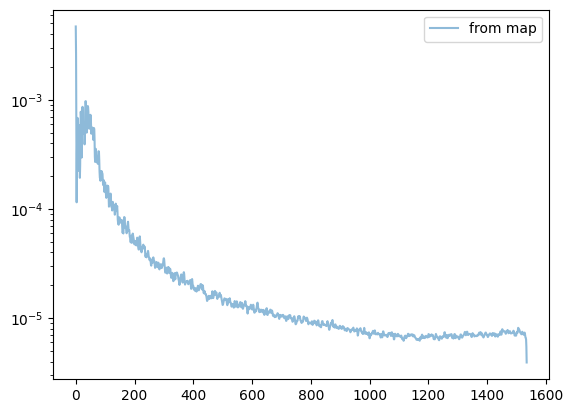

In [17]:
i_z = 0

# cls_ex = out_dict["fidu/cls"][0,:]
map_ex = map_cls[:,i_z]

fig, ax = plt.subplots()

# ax.plot(cls_ex, label=r"from $C_\ell$", alpha=0.5)
ax.plot(map_ex, label="from map", alpha=0.5)

ax.legend(loc="best")
ax.set(yscale="log")

# debug

In [18]:
from msfm.utils import cross_statistics
from msi.utils import input_output

In [19]:
cls_dict = input_output.load_human_summaries(
    base_dir, "cls", return_raw_cls=True, return_fiducial=True, return_grid=False
)

24-09-24 08:33:46 input_output WAR   Returning the raw Cls, this is potentially slow 
24-09-24 08:33:46 input_output INF   Array shapes: 
24-09-24 08:33:46 input_output INF   fiducial/i_example = (35920,) 
24-09-24 08:33:46 input_output INF   fiducial/i_noise   = (35920,) 
24-09-24 08:33:47 input_output INF   fiducial/cls/binned = (35920, 32, 36) 
24-09-24 08:33:47 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-09-24 08:33:57 input_output INF   fiducial/cls/raw   = (35920, 1536, 36) 
24-09-24 08:33:57 input_output INF   Done loading the summaries after 0:00:10.96 


In [20]:
# bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
#     with_lensing=with_lensing,
#     with_clustering=with_clustering,
#     with_cross_z=with_cross_z,
# )

(35920, 400)


[None]

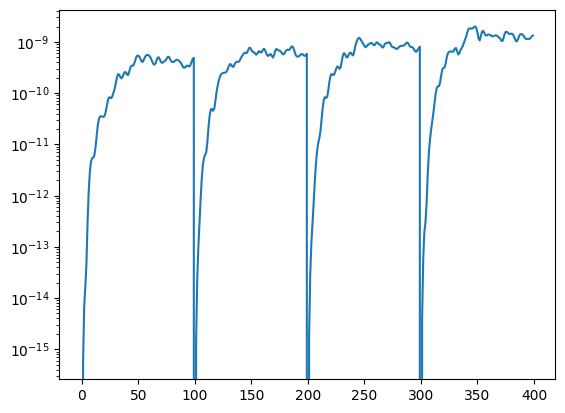

In [21]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=True,
    with_clustering=False,
    with_cross_z=with_cross_z,
)

fidu_cls = cls_dict["fiducial/cls/raw"]
fidu_cls = fidu_cls[..., bin_indices]
fidu_cls = fidu_cls[:, :100, :]
fidu_cls = np.concatenate([fidu_cls[..., i] for i in range(fidu_cls.shape[-1])], axis=-1)
print(fidu_cls.shape)

fig, ax = plt.subplots()
ax.plot(fidu_cls[0])
ax.set(yscale="log")

(35920, 400)


[None]

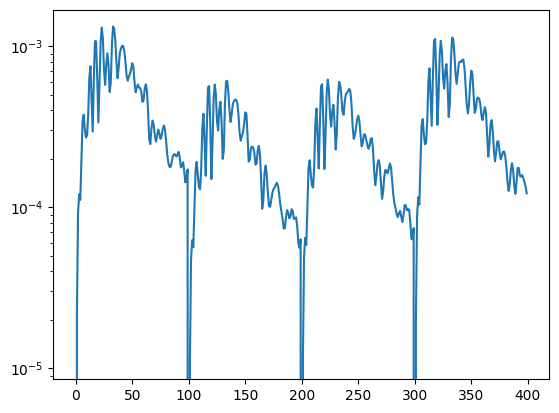

In [22]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=False,
    with_clustering=True,
    with_cross_z=with_cross_z,
)

fidu_cls = cls_dict["fiducial/cls/raw"]
fidu_cls = fidu_cls[..., bin_indices]
fidu_cls = fidu_cls[:, :100, :]
fidu_cls = np.concatenate([fidu_cls[..., i] for i in range(fidu_cls.shape[-1])], axis=-1)
print(fidu_cls.shape)

fig, ax = plt.subplots()
ax.plot(fidu_cls[0])
ax.set(yscale="log")